<center>
<img width=800 src="./figures/ladisk.png">
<br>
<font size="8" color="f00e0e" style="line-height: 150%;" face="garamond"><b>High-speed Image Based Experimental Modal Analysis & Open Source Tools</b></font>
<font size="6" color="f00e0e" style="line-height: 150%;" face="garamond"><br><br><b>Free Online Course</b></font>
<img src="">
<font size="5">July 1st 2020</font>
    
<b>Klemen Zaletelj$^a$, Domen Gorjup$^a$ and Janko Slavič$^a$</b>

$^a$ Faculty of Mechanical Engineering, University of Ljubljana

\* Corresponding email: janko.slavic@fs.uni-lj.si
</center>

<b style="font-size:30px">``https://github.com/ladisk/sdPy``</b>

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-2:-Image-based-methods-for-structural-dynamics" data-toc-modified-id="Part-2:-Image-based-methods-for-structural-dynamics-1">Part 2: Image-based methods for structural dynamics</a></span><ul class="toc-item"><li><span><a href="#Image-based-vibration-measurement---basic-experimental-skills" data-toc-modified-id="Image-based-vibration-measurement---basic-experimental-skills-1.1">Image based vibration measurement - basic experimental skills</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Experimental-setup" data-toc-modified-id="Experimental-setup-1.1.0.1">Experimental setup</a></span></li><li><span><a href="#pyMRAW" data-toc-modified-id="pyMRAW-1.1.0.2">pyMRAW</a></span></li><li><span><a href="#Lighting" data-toc-modified-id="Lighting-1.1.0.3">Lighting</a></span></li><li><span><a href="#Surface-preperation" data-toc-modified-id="Surface-preperation-1.1.0.4">Surface preperation</a></span></li><li><span><a href="#Possible-errors" data-toc-modified-id="Possible-errors-1.1.0.5">Possible errors</a></span></li></ul></li></ul></li><li><span><a href="#Image-based-displacement-identification---pyIDI" data-toc-modified-id="Image-based-displacement-identification---pyIDI-1.2">Image-based displacement identification - pyIDI</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Acquisition-parameters" data-toc-modified-id="Acquisition-parameters-1.2.0.1">Acquisition parameters</a></span></li></ul></li><li><span><a href="#Simplified-Optical-flow" data-toc-modified-id="Simplified-Optical-flow-1.2.1">Simplified Optical-flow</a></span></li><li><span><a href="#The-Lucas-Kanade-method" data-toc-modified-id="The-Lucas-Kanade-method-1.2.2">The Lucas-Kanade method</a></span></li></ul></li><li><span><a href="#Image-based-experimental-modal-analysis" data-toc-modified-id="Image-based-experimental-modal-analysis-1.3">Image-based experimental modal analysis</a></span><ul class="toc-item"><li><span><a href="#Frequency-Response-Functions-(pyFRF)" data-toc-modified-id="Frequency-Response-Functions-(pyFRF)-1.3.1">Frequency Response Functions (pyFRF)</a></span></li><li><span><a href="#Modal-Analysis---camera-data,-only" data-toc-modified-id="Modal-Analysis---camera-data,-only-1.3.2">Modal Analysis - camera data, only</a></span></li><li><span><a href="#Modal-Analysis---the-Hybrid-method" data-toc-modified-id="Modal-Analysis---the-Hybrid-method-1.3.3">Modal Analysis - the Hybrid method</a></span></li></ul></li></ul></li></ul></div>

# Part 2: Image-based methods for structural dynamics

Module imports

In [1]:
import numpy as np
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

import lvm_read
import pyFRF
import pyEMA

Setup default figure style

In [2]:
font_size = 15
fig_size = (16.0, 8.0)

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = fig_size
matplotlib.rcParams['font.size'] = font_size

---

## Image based vibration measurement - basic experimental skills

#### Experimental setup

<img src="figures/experiment_setup.jpg" width="600">

**Excitation with modal hammer**

<video controls loop src="figures/experiment.mp4" width="800" rotate="270deg"/>

High-speed video was recorded using a **Photron SA-Z** monochrome high-speed camera and saved in the **MRAW** raw format.

The simultaneous acceleration measuremnt was performed using NI data acquisition system and saved in the **lvm** data format.

Location of the selected files:

In [3]:
cam_fname = 'data/camera.cih'
lvm_fname = 'data/acceleration.lvm'

#### pyMRAW

Photron MRAW video can be opened in Python using the [pyMRAW](https://github.com/ladisk/pyMRAW) open-source package.

In [4]:
import pyMRAW

In [5]:
video, info = pyMRAW.load_video(cam_fname)

Images are stored in the ``mraw`` attribute.

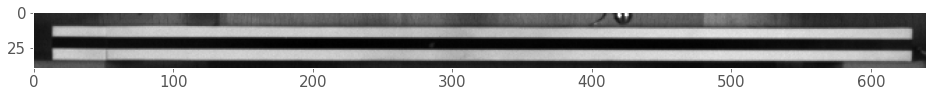

In [6]:
sequential_image_nr = 100

plt.imshow(video[sequential_image_nr], cmap='gray')
plt.grid(False)

*This example footage is for presentation purposes only and was made to be suitable for online sharing.*

*Normaly image acquisation parameters such as frame rate and image resolution would be chosen as high as possible to obtain more precise results.*

<video controls loop src="figures/video.MOV" width="950" rotate="270deg"/>

#### Lighting
Lighting conditions are very important when using high-speed camera. To obtain optimal lighting conditions, a histogram of pixel intensity is viewed. An example of a well balanced historgram is shown.

In [7]:
def figure(selected_frame = 0, x0 = 300, y0 = 9, d = 25):
    roi = video[selected_frame, y0:y0+d, x0:x0+d]

    fig, ax = plt.subplots(2)
    ax[0].imshow(video[selected_frame], cmap='gray')
    ax[1].hist(roi.flatten(), bins=50);
    # Formating
    ax[0].add_patch(patches.Rectangle((x0, y0), d, d, fill=False, color='r', linewidth=2))
    ax[0].grid(False)
    ax[1].set_xlabel('Grayscale value [/]')
    ax[1].set_ylabel('n pixels [/]')
    plt.tight_layout()

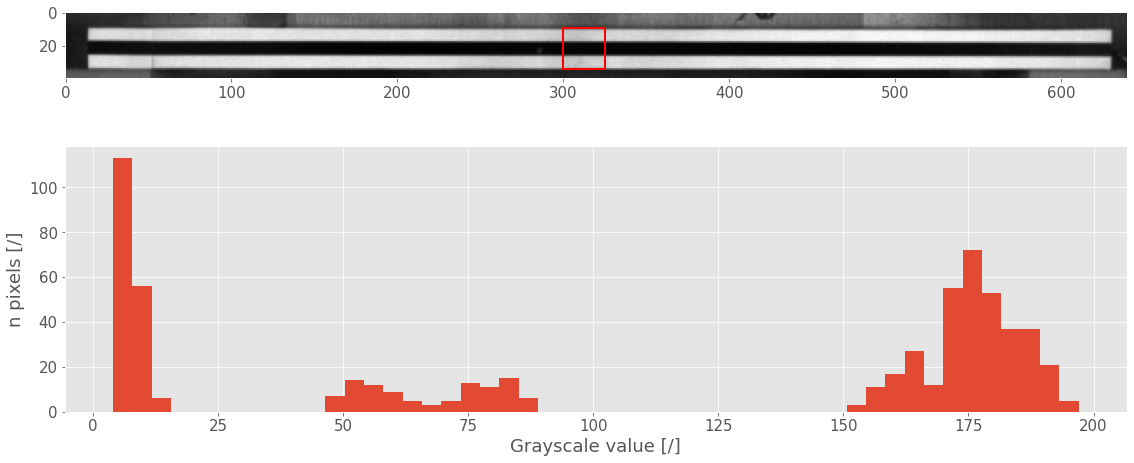

In [8]:
figure(selected_frame = 0, x0 = 300, y0 = 9, d = 25)

#### Surface preperation
In order for gradient-based methods to work, sufficient gradient must be present on the images. Surface preperations is therefor necessary.

Stripe pattern and random speckle pattern generation is implemented in the [speckle-pattern][1] python module. In this case, horizontal stripes were used.

[1]: https://github.com/ladisk/speckle_pattern

In [9]:
grad0, grad1 = np.gradient(video[0].astype(float)) # gradient computation

In [10]:
def figure_surface(selected_frame = 0, x0 = 200):
    fig, ax = plt.subplots(2)
    ax[0].imshow(video[selected_frame], cmap='gray')
    ax[1].plot(video[selected_frame, :, x0], label='Grayscale value')
    ax[1].plot(grad0[:, x0], label='Gradient')
    # Formating
    ax[0].vlines(x0, 0, 40, colors='r', linewidth=3)
    ax[0].text(x0+10, -5, 'Cross section')
    ax[0].arrow(x0+50, 5, -35, 20, color='r', width=3)
    ax[0].grid(False)
    ax[1].set_xlabel('Image height [px]')
    ax[1].set_ylabel('Grayscale/gradient value [/]')
    plt.legend()
    plt.tight_layout()

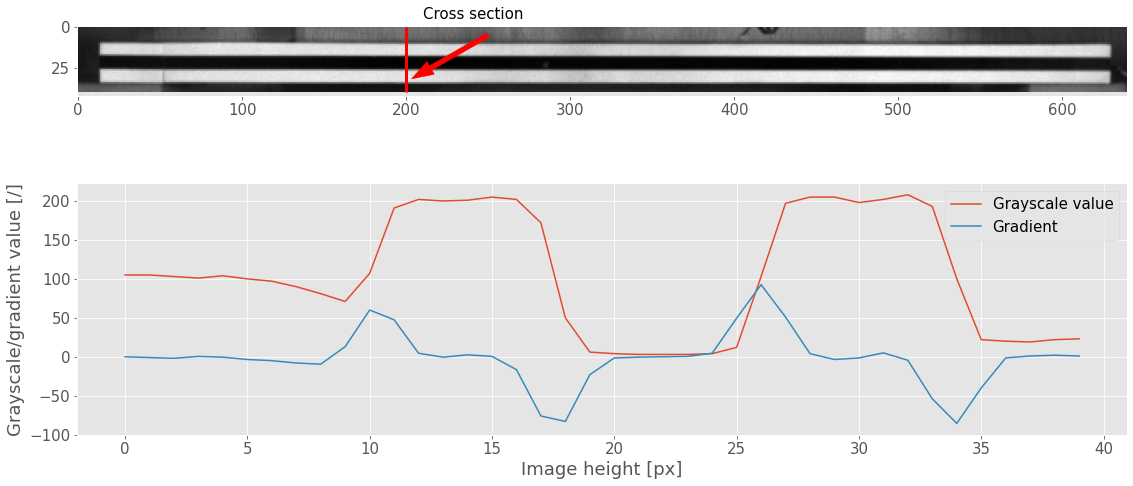

In [11]:
figure_surface(selected_frame = 0, x0 = 200)

#### Possible errors

**Out of focus image**
The right side of the beam is in focus, while the left side is not.

In [12]:
layout_fname = r'data/focus.cih'
video_layout, info_layout = pyMRAW.load_video(layout_fname)

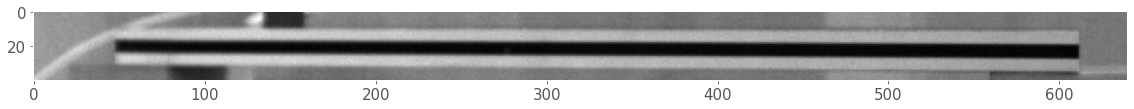

In [13]:
fig, ax = plt.subplots()
ax.imshow(video_layout[0], 'gray')
ax.grid(False)
plt.tight_layout()

**Improper lighting**

In [14]:
light_fname = r'data/illumination.cih'
video_light, info_layout = pyMRAW.load_video(light_fname)

In [15]:
selected_frame = 0
y0, d = 9, 20

def show(x0):
    roi = video_light[selected_frame, y0:y0+d, x0:x0+d*2]
    fig, ax = plt.subplots(2)
    ax[0].imshow(video_light[selected_frame], cmap='gray')
    ax[1].hist(roi.flatten(), bins=50);
    # Formating
    ax[0].add_patch(patches.Rectangle((x0, y0), d*2, d, fill=False, color='r', linewidth=2))
    ax[0].grid(False)
    ax[1].set_xlabel('Grayscale value [/]')
    ax[1].set_ylabel('n pixels [/]')
    ax[1].set_xlim([0, 260])
    plt.tight_layout()

In [16]:
interact(show, x0=(75, 550, 50));

interactive(children=(IntSlider(value=275, description='x0', max=550, min=75, step=50), Output()), _dom_classe…

---

## Image-based displacement identification - pyIDI

**pyIDI** is an open-source package, designed for image-based displacement measurement with structural dynamics in mind.

It implements different algrithms for image displacement identification, namely the *Simplified Optical Flow* method and *Digital Image Correlation* based on the Lucas-Kanade algorithm.

You can find more info on the [pyIDI GitHub repository webpage](https://github.com/ladisk/pyidi).

MRAW video can be opened using the pyIDI package directly:

In [17]:
import pyidi

In [18]:
video = pyidi.pyIDI(cam_fname)

The acquired images are now accessed in the ``mraw`` attribute

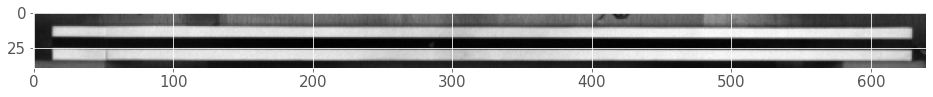

In [19]:
plt.imshow(video.mraw[0], cmap='gray')

#### Acquisition parameters

The parameters that were used when recording can be found in the ``info`` attribute:

In [20]:
video.info

{'Date': '2018/12/17',
 'Time': '12:48',
 'Camera Type': 'FASTCAM SA-Z type 2100K-M-64GB',
 'Head Type': 'Unknown Child Device',
 'Camera ID': 11,
 'Camera Number': 0,
 'Head Number': 1,
 'Max Head Number': 1,
 'Scene Name': '',
 'User Defined Camera Name': '',
 'Session Number': '',
 'Date Record': 'Unknown',
 'Time Record': 'Unknown',
 'Trigger Time': 0,
 'Record Rate(fps)': 15000,
 'Shutter Speed(s)': '1/15371',
 'Trigger Mode': 'Start',
 'Original Total Frame': 7500,
 'Total Frame': 3750,
 'Start Frame': 0,
 'Correct Trigger Frame': 0,
 'Save Step': 1,
 'Image Width': 640,
 'Image Height': 40,
 'Color Type': 'Mono',
 'Color Bit': 8,
 'File Format': 'MRaw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Higher',
 'Digits Of File Number': 6,
 'Device Last Error': '-1:0xffffffff',
 'Comment Text': '',
 'AnalogBoard Channel Num': 0,
 'Zero Frame': 'Exist',
 'Shutter Type2(nsec)': 65060,
 'Edge Enhance': 0,
 'Pre LUT Mode': 'DEF1',
 'Pre LUT Brightness': 0,
 'Pre LUT Contrast': 0,
 '

### Simplified Optical-flow

Basic formulation:
$$
s(x_j,y_k,t)=\frac{I_0(x_j,y_k)-I(x_j,y_k,t)}{|\nabla I_0|}
$$

As used by [Javh et al.][1] ([pdf][2]).

[1]: https://www.sciencedirect.com/science/article/pii/S0888327016304770
[2]: http://lab.fs.uni-lj.si/ladisk/?what=abstract&ID=179

First, the reference image of the loaded video must be computed:

In [21]:
reference_image = np.average(video.mraw[:10], axis=0)

and gradients in ``x`` (1) and ``y`` (0) directions:

In [22]:
grad_y, grad_x = np.gradient(reference_image)

Points with the highest absolute value of gradient in **vertical** direction are determined and selected for analysis:

In [23]:
border = 20
border_h = 12
n = 2
N = 16
w = np.arange(border, reference_image.shape[1]-border, np.abs(border - reference_image.shape[1]-border)//N)
h = np.argsort(np.abs(grad_y[border_h:-border_h, w]), axis=0)[-n:, :].T + border_h
inds = np.column_stack((h.flatten(), w.repeat(n)))

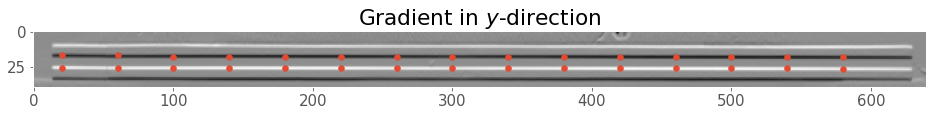

In [24]:
fig, ax = plt.subplots()
ax.imshow(grad_y, cmap='gray')
ax.scatter(inds[:, 1], inds[:, 0])
ax.grid(False)
ax.set_title('Gradient in $y$-direction');

Select the shown point for analysis:

In [25]:
video.set_points(points=inds)

Displacement computation using the Smlified Optical Flow method, implemented in ``pyidi``:

In [26]:
video.set_method(method='sof',
                mean_n_neighbours=n) # two consecutive points will be averaged

``get_displacements()`` method computes the displacements.

In [27]:
pixels_to_m = 8e-5

In [28]:
displacements = video.get_displacements() * pixels_to_m

100%|█████████████████████████████████████████████████████████| 3750/3750 [00:02<00:00, 1549.02it/s]

Averaging...
Finished!


In [29]:
location = 1

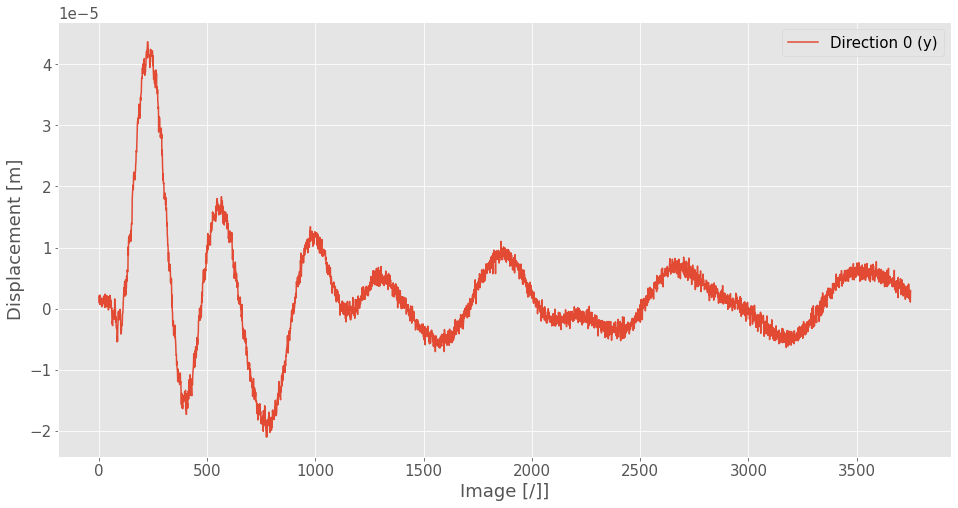

In [30]:
fig, ax = plt.subplots()
ax.plot(displacements[location, :, 0], label='Direction 0 (y)');
ax.set_xlabel('Image [/]]')
ax.set_ylabel('Displacement [m]')
plt.legend()

### The Lucas-Kanade method

By solving an overdetermined system of optical flow equations for a specified region of the image, 2D displacements of the subset can be calculated:

$$
\begin{equation}
	\begin{bmatrix}
		\Delta x \\
		\Delta y
	\end{bmatrix} =
	\begin{bmatrix}
		\sum g_x^2 &\sum  g_x \, g_y \\
		\sum  g_x \, g_y &\sum g_y^2
	\end{bmatrix}^{-1}
	\begin{bmatrix}
		\sum g_x \, (f-g) \\
		\sum g_y \, (f-g)
	\end{bmatrix}
\end{equation}
$$

where 

$f(\mathbf{x}) \dots$ current (displaced) image

$g(\mathbf{x}) \dots$ reference image

Select points for analysis:

In [31]:
points_lk = np.column_stack([np.ones_like(w)*video.info['Image Height']//2, w])

In [32]:
video.set_points(points_lk)

Set and configure the selected method:

In [33]:
video.set_method('lk')

In [34]:
video.method.configure(roi_size=(21, 21), max_nfev=10, int_order=3, processes=2)

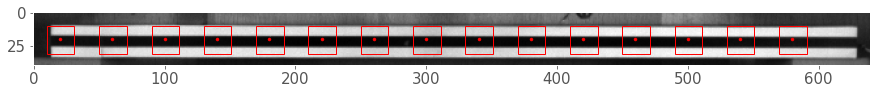

In [35]:
video.show_points()

In [36]:
displacements_lk = video.get_displacements() * pixels_to_m # this might take a couple of minutes

In [37]:
# displacements_lk = np.load('data/displacements_lk.npy') # you can load precomputed results instead

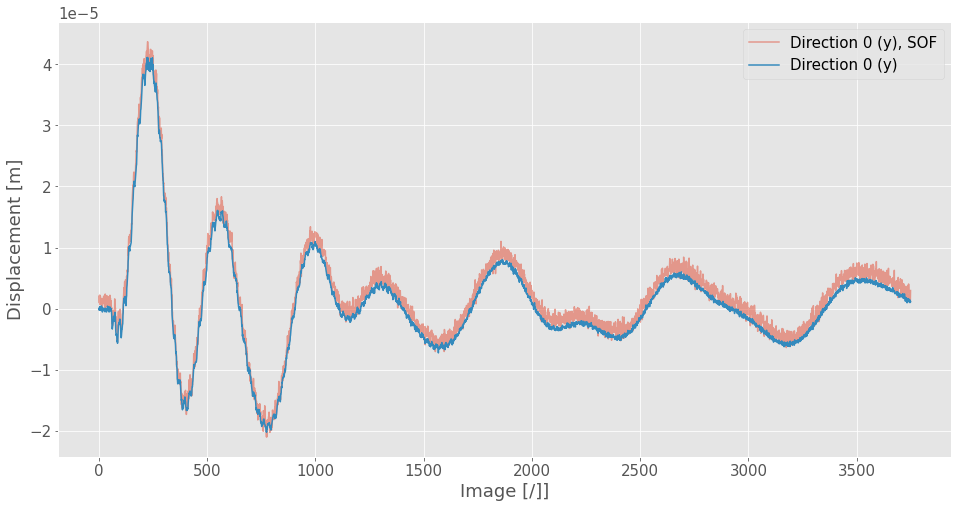

In [38]:
fig, ax = plt.subplots()
ax.plot(displacements[location, :, 0], alpha=0.5, label='Direction 0 (y), SOF');
ax.plot(displacements_lk[location, :, 0], label='Direction 0 (y)')
ax.set_xlabel('Image [/]]')
ax.set_ylabel('Displacement [m]')
plt.legend()

In [39]:
displacements = displacements_lk

---

## Image-based experimental modal analysis

Prepare functions for modal data visualization

In [40]:
def show_modal_data(nat_freq, damping):
    """Show modal data in a table-like structure."""
    print('   Nat. f.      Damping')
    print(23*'-')
    for i, f in enumerate(nat_freq):
        print(f'{i+1}) {f:6.1f}\t{damping[i]:5.4f}')
        

def plot_mode_shape(shape, axis, style='o-', frequency=None, **kwargs):
    """Plot a mode shape in a consistent fashion."""
    plot = axis.plot(shape / np.max(np.abs(shape)) * np.sign(shape[0]), 
                     style, **kwargs)
    if frequency is not None:
        axis.set_title(f'Mode shape - {frequency:.0f} Hz')
    axis.set_yticks([])
    plt.tight_layout()

### Frequency Response Functions (pyFRF)

First the FFT of displacement is computed:

In [41]:
N = int(video.info['Total Frame'])
dt = 1/int(video.info['Record Rate(fps)'])

In [42]:
T = dt*N

In [43]:
upper_f_limit = 4000 # upper observed frequency

In [44]:
freq_cam = np.fft.rfftfreq(N, dt)
fft_cam = np.fft.rfft(displacements[:, :, 0], N) *2/N

Later the frequency range below `upper_f_limit` Hz is used:

In [45]:
fft_cam = np.copy(fft_cam[:, freq_cam<upper_f_limit])
freq_cam = np.copy(freq_cam[freq_cam<upper_f_limit])

The FFT of force measurement is (also limited to `upper_f_limit`):

In [46]:
lvm = lvm_read.read(lvm_fname)
force = lvm[0]['data'][:-30, 1] # 30 pre-samples
N = len(force)//4 # the video was captured for 1/4 of a second
dt = lvm[0]['Delta_X'][1]

fft_force = np.fft.rfft(force, N) *2/N
freq_force = np.fft.rfftfreq(N, dt)

fft_force = np.copy(fft_force[freq_force<upper_f_limit])
freq_force = np.copy(freq_force[freq_force<upper_f_limit])

Since only one measurement was used, the FRF is determined by:

In [47]:
frf_cam = fft_cam/fft_force 

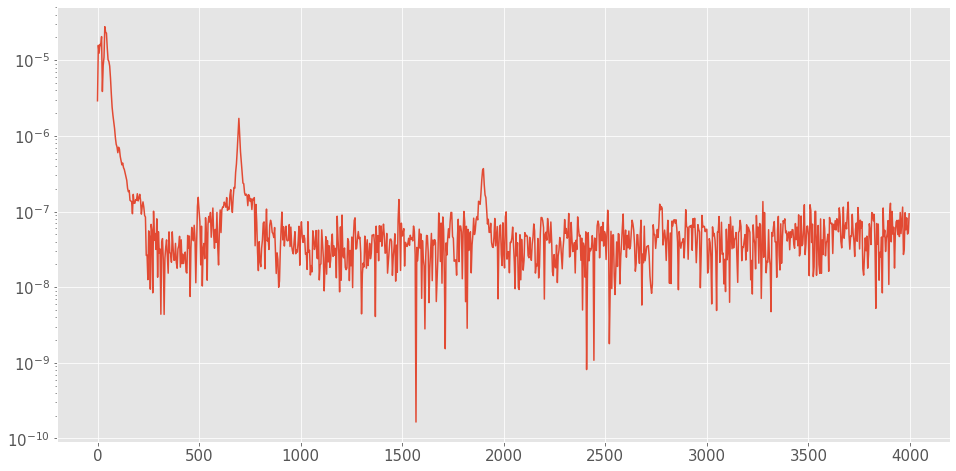

In [48]:
plt.semilogy(freq_cam, np.abs(frf_cam[location]));

### Modal Analysis - camera data, only

Modal analysis can be made using ``pyEMA`` package, accessible on [PyPI][1].

[1]: https://pypi.org/project/pyEMA/

In [49]:
cam = pyEMA.Model(frf_cam, freq_cam, pol_order_high=50, upper=upper_f_limit)

Poles are computed:

In [50]:
cam.get_poles(show_progress=True)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 258.03it/s]


Stable poles can be picked in the stability chart, or preditermind by passing in approximate natural frequencies (picking poles works only in the interactive mode, use magic command: %matplotlib qt).

In [51]:
cam.select_poles()

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 249.86it/s]


<Figure size 1152x576 with 0 Axes>

In [52]:
cam.print_modal_data()

   Nat. f.      Damping
-----------------------
1)  695.4	-0.0000
2) 1897.8	-0.0004
3) 2467.0	-0.0045


After the stable poles are determind, a ``lsfd`` method can be called to reconstruct the FRF:

In [53]:
frf_rec, shapes_cam = cam.get_constants(FRF_ind='all')

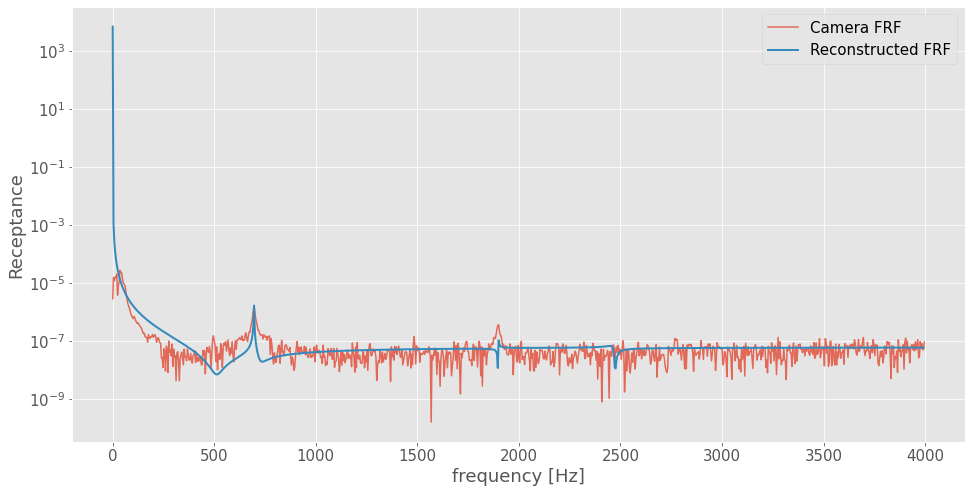

In [54]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[location]), label='Camera FRF', alpha=0.8)
ax.semilogy(freq_cam[:-1], np.abs(frf_rec[location]), label='Reconstructed FRF', lw=2)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Receptance')
plt.legend();

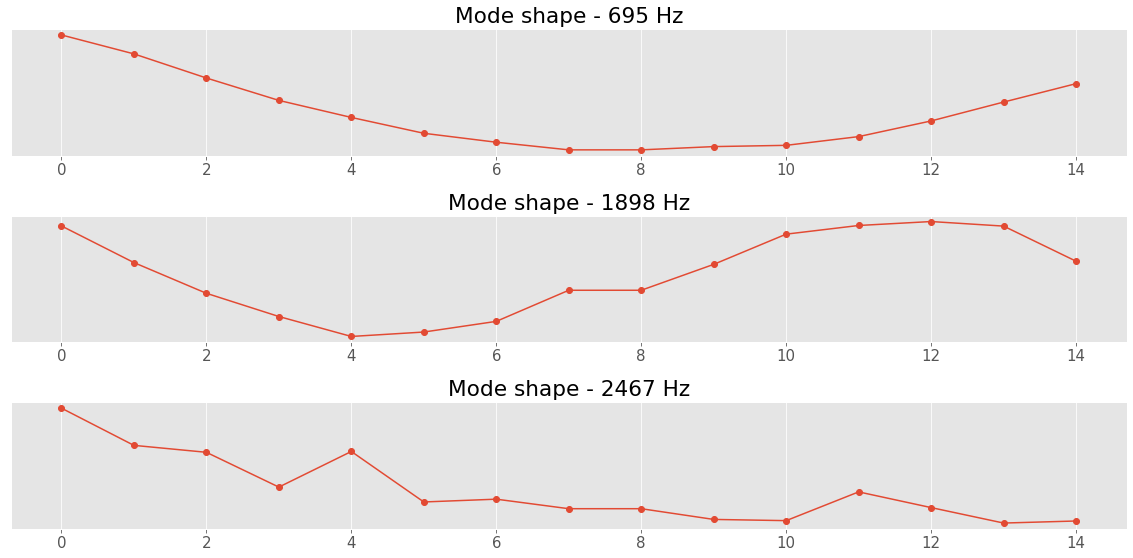

In [55]:
fig, ax = plt.subplots(shapes_cam.shape[1])
for i, a in enumerate(ax):
    plot_mode_shape(shapes_cam[:, i], axis=a, frequency=cam.nat_freq[i])

### Modal Analysis - the Hybrid method

The Hybrid method was developed by Javh et al. Further details can be found [here][1] ([pdf][2]).

First, the acceleration and force data are needed:

[1]: https://www.sciencedirect.com/science/article/pii/S0888327017302637
[2]: http://lab.fs.uni-lj.si/ladisk/?what=abstract&ID=192

In [56]:
hyb_acc = lvm[0]['data'][:-30, 0] * 9.81 # acceleration data (converted to m/s**2)

Compute the accelerometer FRF using ``pyFRF``:

In [57]:
frf = pyFRF.FRF(
    sampling_freq=1/dt,
    exc=force,
    resp=hyb_acc,
    exc_window='None',
    resp_type='a',
    resp_window='None')

In [58]:
freq_acc = frf.get_f_axis()
frf_acc = frf.get_FRF(form='receptance')

Only the frequencies lower than `upper_f_limit` Hz are observed:

In [59]:
frf_acc = frf_acc[freq_acc<upper_f_limit]
freq_acc = freq_acc[freq_acc<upper_f_limit]

The location of acceleration measurement is at identified camera point with index 3:

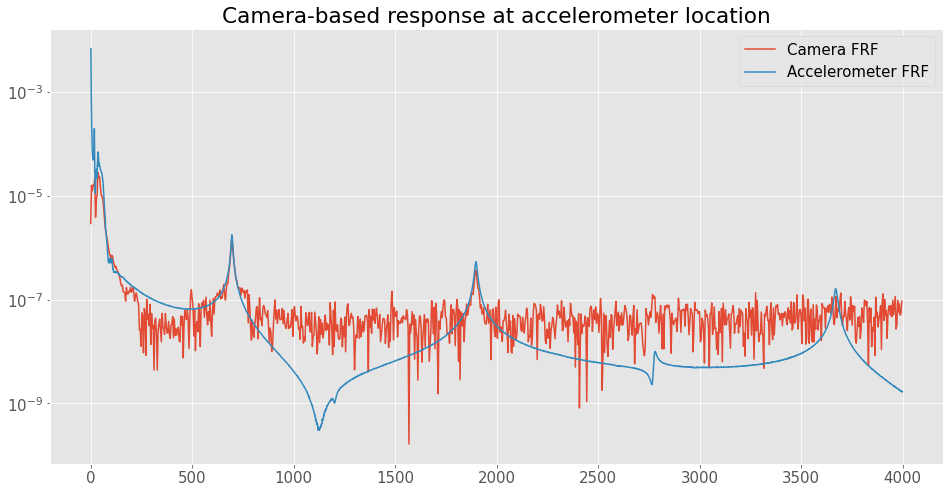

In [60]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[location]), label='Camera FRF')
ax.semilogy(freq_acc, np.abs(frf_acc), label='Accelerometer FRF')
ax.set_title('Camera-based response at accelerometer location')
plt.legend();

Next the ``lscf`` object can be created and poles are computed for the hybrid method:

In [61]:
acc = pyEMA.Model(frf_acc[1:], freq_acc[1:], pol_order_high=50, upper=upper_f_limit)

In [62]:
acc.get_poles(show_progress=True)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 295.33it/s]


In [63]:
acc.stab_chart(acc.all_poles)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 270.34it/s]


SHIFT + LEFT mouse button to pick a pole.
SHIFT + RIGHT mouse button to erase the last pick.
1. Frequency: ~705 -->	694.9894227335782 Hz	(xi = 0.0047)
2. Frequency: ~1898 -->	1897.549467474093 Hz	(xi = 0.0031)
3. Frequency: ~2751 -->	2777.341778329317 Hz	(xi = 0.0024)
4. Frequency: ~3667 -->	3671.1880138101633 Hz	(xi = 0.0020)


<Figure size 1152x576 with 0 Axes>

In [64]:
acc.print_modal_data()

   Nat. f.      Damping
-----------------------
1)  695.0	0.0047
2) 1897.5	0.0031
3) 2777.3	0.0024
4) 3671.2	0.0020


The poles computed based on accleration data are more reliable. These poles can now be used in reconstruction of FRFs from camera. A new ``lscf`` object is made with camera FRF:

In [65]:
cam_hyb = pyEMA.Model(frf_cam, freq_cam)

Next, the reconstruction is done using accleration-determined poles:

In [66]:
frf_hyb, shapes_hybrid = cam_hyb.get_constants(whose_poles=acc)

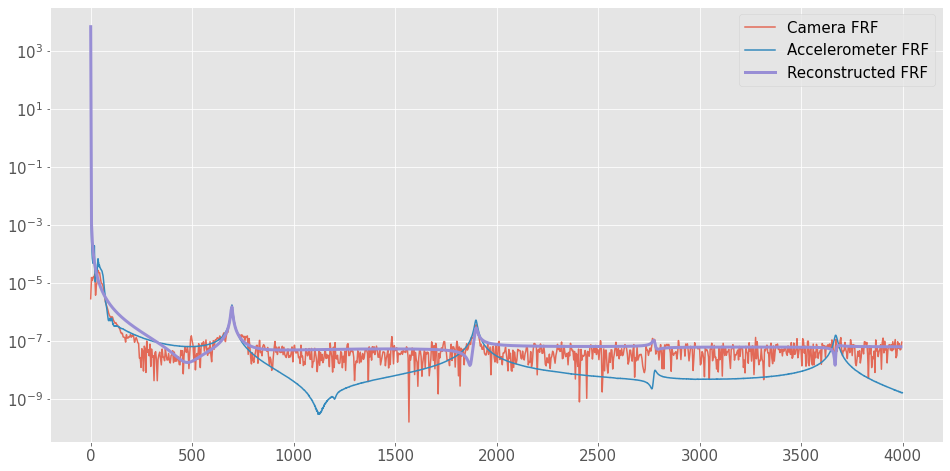

In [67]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[location]), label='Camera FRF', alpha=0.8)
ax.semilogy(freq_acc, np.abs(frf_acc), label='Accelerometer FRF')
ax.semilogy(freq_cam[:-1], np.abs(frf_hyb[location]), label='Reconstructed FRF', lw=3)
plt.legend();

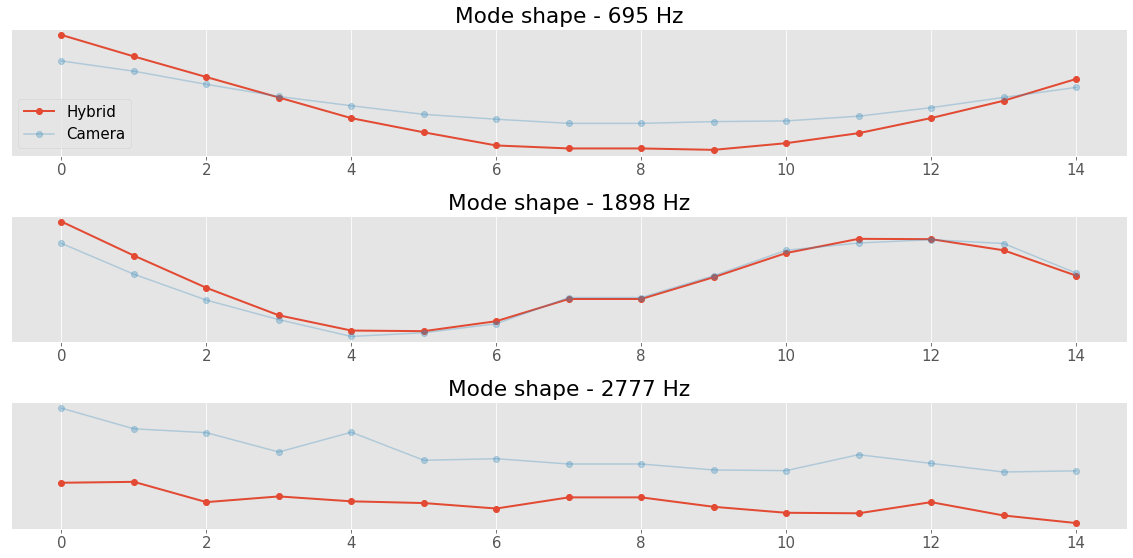

In [68]:
fig, ax = plt.subplots(shapes_cam.shape[-1])
for i, a in enumerate(ax):
    cam_freq = cam.nat_freq[i]
    hybrid_f_index = np.argmin(np.abs(acc.nat_freq - cam_freq))
    plot_mode_shape(shapes_hybrid[:, hybrid_f_index], axis=a, 
                    frequency=acc.nat_freq[hybrid_f_index], lw=2, label='Hybrid')
    plot_mode_shape(shapes_cam[:, i], axis=a , alpha=0.3, label='Camera')
    a.set_yticks([])
ax[0].legend()

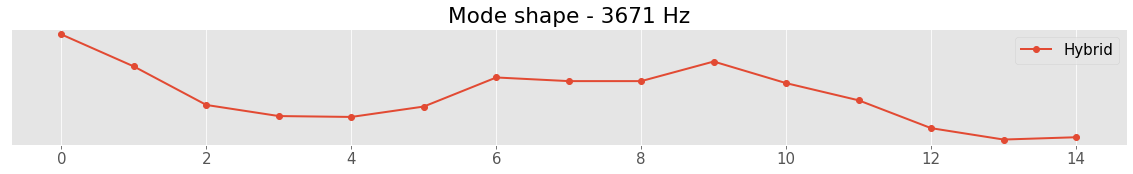

In [69]:
plt.figure(figsize=(fig_size[0], fig_size[1]/3))
plot_mode_shape(shapes_hybrid[:, -1], axis=plt.gca(), 
                frequency=acc.nat_freq[-1], lw=2, label='Hybrid')
plt.legend()

---